In [1]:
import numpy as np
from scipy import spatial
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [2]:
import pandas as pd
data = pd.read_csv('HateSpeechDatasetBalanced.csv')
data.head()

,Content,Label
0,denial of normal the con be asked to comment o...,1
1,just by being able to tweet this insufferable ...,1
2,that is retarded you too cute to be single tha...,1
3,thought of a real badass mongol style declarat...,1
4,afro american basho,1


In [3]:
import re
def preprocess_text(sen):
  text = re.compile(r'<[^>]+>').sub('', sen) # Remove HTML tags using a regular expression
  text = re.sub(r'[^a-zA-Z0-9\s]', '', text).lower() # Remove non-alphanumeric characters and convert to lowercase
  text = re.sub(r"\s+[a-zA-Z]\s+", ' ', text) # Remove single characters
  text = text.strip() # Remove leading and trailing whitespace
  text = re.sub(r'\s+', ' ', text) # Replace multiple spaces with a single space
  return text # Return the cleaned text

In [4]:
X = []
sentences = list(data['Content'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, data["Label"], test_size=0.20, random_state=42)

In [6]:
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [7]:
from keras.preprocessing.sequence import pad_sequences

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [8]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

def embedding_for_vocab(filepath, word_index,
                        embedding_dim):
    vocab_size = len(word_index) + 1

    # Adding again 1 because of reserved 0 index
    embedding_matrix_vocab = np.zeros((vocab_size,
                                       embedding_dim))

    with open(filepath, encoding="utf8") as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word]
                embedding_matrix_vocab[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix_vocab

In [56]:
# matrix for vocab: word_index
embedding_dim = 50
embedding_matrix_vocab = embedding_for_vocab('glove.6B.50d.txt', tokenizer.word_index, embedding_dim)

In [78]:
scores = {}

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/50
3631/3631 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - acc: 0.7160 - loss: 0.5457 - val_acc: 0.7479 - val_loss: 0.5028
Epoch 2/50
3631/3631 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - acc: 0.7565 - loss: 0.4893 - val_acc: 0.7517 - val_loss: 0.4947
Epoch 3/50
3631/3631 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - acc: 0.7751 - loss: 0.4586 - val_acc: 0.7647 - val_loss: 0.4785
Epoch 4/50
3631/3631 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - acc: 0.7949 - loss: 0.4275 - val_acc: 0.7694 - val_loss: 0.4805
Epoch 5/50
3631/3631 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - acc: 0.8154 - loss: 0.3922 - val_acc: 0.7690 - val_loss: 0.4845
Epoch 6/50
3631/3631 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - acc: 0.8304 - loss: 0.3642 - val_acc: 0.7663 - val_loss: 0.5051
18153/18153 ━━━━━━━━━━━━━━━━━━━━ 30s 2ms/step - acc: 0.8413 - loss: 0.3494
18153/18153 ━━━━━━━━━━━━━━━━━━━━ 30s 2ms/step - acc: 0.8413 - loss: 0.3494


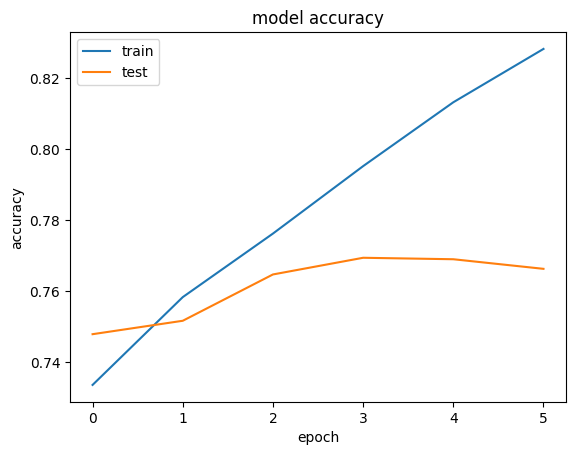

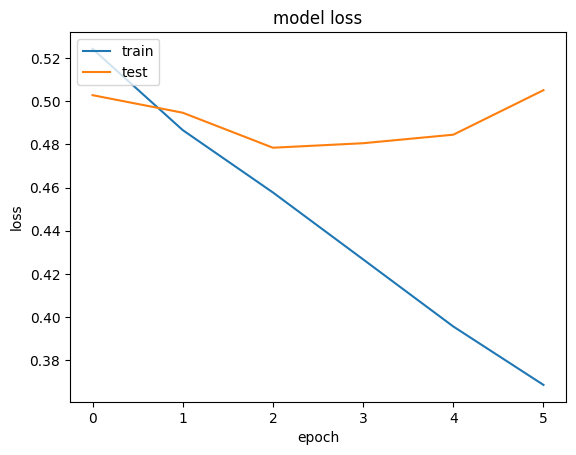

In [80]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dropout, Embedding, Flatten

vocab_size = len(tokenizer.word_index) + 1
model = Sequential()
embedding_layer = Embedding(vocab_size, 50, weights=[embedding_matrix_vocab], input_length=maxlen , trainable=False)
model.add(embedding_layer)
model.add(Flatten())
model.add(Dense(128, activation='sigmoid'))
model.add(Dense(256, activation='sigmoid'))
model.add(Dense(128, activation='sigmoid'))
model.add(Dense(64, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))

from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, batch_size=128, epochs=50, verbose=1, validation_split=0.2, callbacks=[early_stopping])

scores.update({'basic_ff_train': model.evaluate(X_train, y_train, verbose=1),
              'basic_ff_test': model.evaluate(X_train, y_train, verbose=1)})

import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

Epoch 1/50
3631/3631 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - acc: 0.7646 - loss: 0.4790 - val_acc: 0.8064 - val_loss: 0.4135
Epoch 2/50
3631/3631 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - acc: 0.8149 - loss: 0.3972 - val_acc: 0.8151 - val_loss: 0.3958
Epoch 3/50
3631/3631 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - acc: 0.8302 - loss: 0.3697 - val_acc: 0.8200 - val_loss: 0.3898
Epoch 4/50
3631/3631 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - acc: 0.8401 - loss: 0.3491 - val_acc: 0.8183 - val_loss: 0.3940
Epoch 5/50
3631/3631 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - acc: 0.8486 - loss: 0.3324 - val_acc: 0.8218 - val_loss: 0.3898
Epoch 6/50
3631/3631 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - acc: 0.8556 - loss: 0.3174 - val_acc: 0.8204 - val_loss: 0.3968
18153/18153 ━━━━━━━━━━━━━━━━━━━━ 31s 2ms/step - acc: 0.8671 - loss: 0.2978
18153/18153 ━━━━━━━━━━━━━━━━━━━━ 32s 2ms/step - acc: 0.8671 - loss: 0.2978


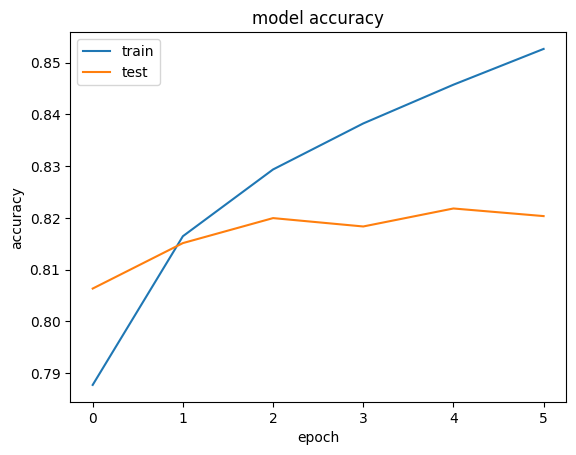

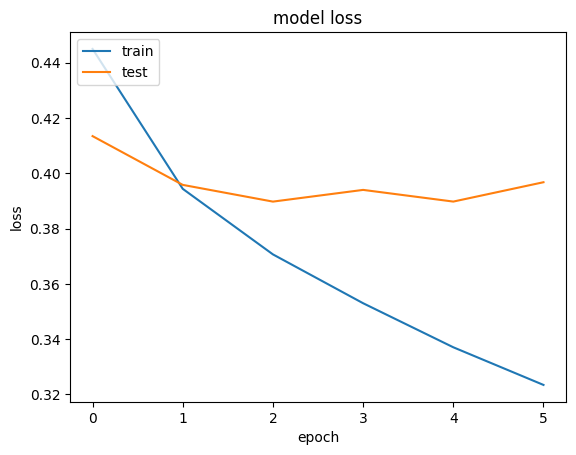

In [86]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dropout, Embedding, Flatten

vocab_size = len(tokenizer.word_index) + 1

model = Sequential()
embedding_layer = Embedding(vocab_size, 50, weights=[embedding_matrix_vocab], input_length=maxlen , trainable=False)
model.add(embedding_layer)
model.add(Conv1D(128, 5, activation='relu'))
model.add(MaxPooling1D(5))
model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))

from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, batch_size=128, epochs=50, verbose=1, validation_split=0.2, callbacks=[early_stopping])

scores.update({'cnn_train': model.evaluate(X_train, y_train, verbose=1),
              'cnn_test': model.evaluate(X_train, y_train, verbose=1)})

import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

Epoch 1/50
3631/3631 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - acc: 0.7376 - loss: 0.6907 - val_acc: 0.7714 - val_loss: 0.5242
Epoch 2/50
3631/3631 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - acc: 0.7718 - loss: 0.5176 - val_acc: 0.7738 - val_loss: 0.5084
Epoch 3/50
3631/3631 ━━━━━━━━━━━━━━━━━━━━ 27s 5ms/step - acc: 0.7782 - loss: 0.5050 - val_acc: 0.7761 - val_loss: 0.5137
Epoch 4/50
3631/3631 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - acc: 0.7793 - loss: 0.4991 - val_acc: 0.7633 - val_loss: 0.5151
Epoch 5/50
3631/3631 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - acc: 0.7804 - loss: 0.4969 - val_acc: 0.7806 - val_loss: 0.5025
Epoch 6/50
3631/3631 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - acc: 0.7812 - loss: 0.4942 - val_acc: 0.7820 - val_loss: 0.4946
Epoch 7/50
3631/3631 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - acc: 0.7811 - loss: 0.4943 - val_acc: 0.7856 - val_loss: 0.4927
Epoch 8/50
3631/3631 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - acc: 0.7828 - loss: 0.4899 - val_acc: 0.7833 - val_loss: 0.4885
Epoch 9/50
3631/3631 ━━━━━━━━━━━

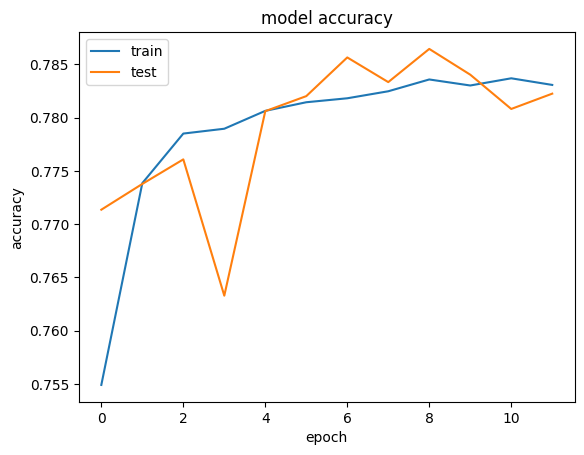

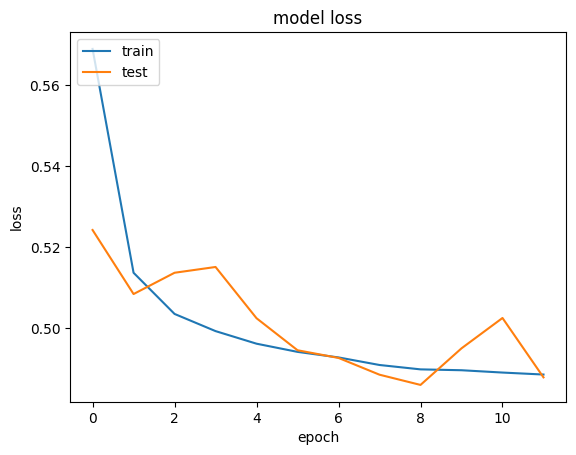

In [87]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dropout, Embedding, Flatten
from keras import regularizers


vocab_size = len(tokenizer.word_index) + 1

model = Sequential()
embedding_layer = Embedding(vocab_size, 50, weights=[embedding_matrix_vocab], input_length=maxlen , trainable=False)
model.add(embedding_layer)
model.add(Conv1D(128, 5, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(MaxPooling1D(5))
model.add(Conv1D(128, 5, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))

from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, batch_size=128, epochs=50, verbose=1, validation_split=0.2, callbacks=[early_stopping])

scores.update({'cnn_l2_train': model.evaluate(X_train, y_train, verbose=1),
              'cnn_l2_test': model.evaluate(X_train, y_train, verbose=1)})

import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/50
3631/3631 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - acc: 0.7322 - loss: 0.7038 - val_acc: 0.7703 - val_loss: 0.5256
Epoch 2/50
3631/3631 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - acc: 0.7681 - loss: 0.5266 - val_acc: 0.7797 - val_loss: 0.5065
Epoch 3/50
3631/3631 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - acc: 0.7755 - loss: 0.5126 - val_acc: 0.7779 - val_loss: 0.5153
Epoch 4/50
3631/3631 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - acc: 0.7755 - loss: 0.5086 - val_acc: 0.7821 - val_loss: 0.4967
Epoch 5/50
3631/3631 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - acc: 0.7767 - loss: 0.5061 - val_acc: 0.7834 - val_loss: 0.4945
Epoch 6/50
3631/3631 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - acc: 0.7786 - loss: 0.5036 - val_acc: 0.7778 - val_loss: 0.5002
Epoch 7/50
3631/3631 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - acc: 0.7771 - loss: 0.5032 - val_acc: 0.7717 - val_loss: 0.5036
Epoch 8/50
3631/3631 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - acc: 0.7777 - loss: 0.5042 - val_acc: 0.7807 - val_loss: 0.4958
18153/18153 ━━━━━━━━━━━━━━━━━━━━

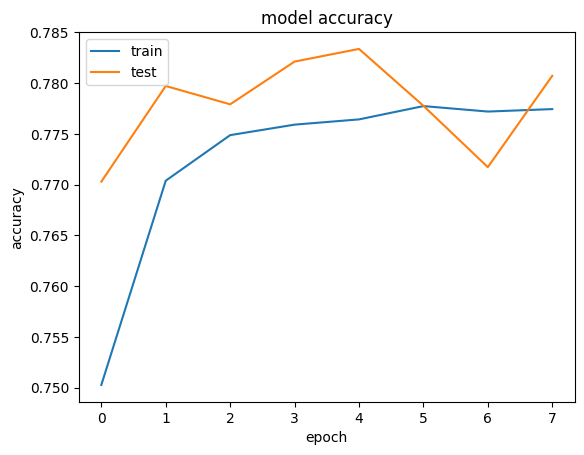

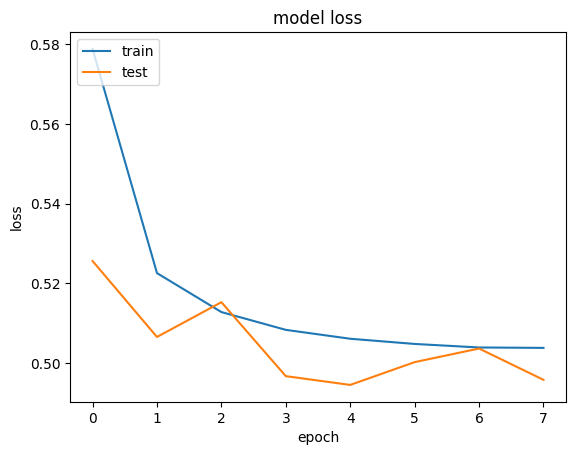

In [88]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dropout, Embedding, Flatten
from keras import regularizers


vocab_size = len(tokenizer.word_index) + 1

model = Sequential()
embedding_layer = Embedding(vocab_size, 50, weights=[embedding_matrix_vocab], input_length=maxlen , trainable=False)
model.add(embedding_layer)
model.add(Conv1D(128, 5, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(MaxPooling1D(5))
model.add(Conv1D(128, 5, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, batch_size=128, epochs=50, verbose=1, validation_split=0.2, callbacks=[early_stopping])

scores.update({'cnn_l2_dropout_train': model.evaluate(X_train, y_train, verbose=1),
              'cnn_l2_dropout_test': model.evaluate(X_train, y_train, verbose=1)})

import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

Epoch 1/50
3631/3631 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - acc: 0.5970 - loss: 3.2406 - val_acc: 0.7196 - val_loss: 1.7173
Epoch 2/50
3631/3631 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - acc: 0.7211 - loss: 1.4947 - val_acc: 0.7343 - val_loss: 1.0363
Epoch 3/50
3631/3631 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - acc: 0.7346 - loss: 0.9692 - val_acc: 0.7428 - val_loss: 0.8129
Epoch 4/50
3631/3631 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - acc: 0.7424 - loss: 0.7872 - val_acc: 0.7478 - val_loss: 0.7140
Epoch 5/50
3631/3631 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - acc: 0.7474 - loss: 0.7025 - val_acc: 0.7524 - val_loss: 0.6602
Epoch 6/50
3631/3631 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - acc: 0.7534 - loss: 0.6544 - val_acc: 0.7554 - val_loss: 0.6269
Epoch 7/50
3631/3631 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - acc: 0.7595 - loss: 0.6232 - val_acc: 0.7614 - val_loss: 0.6028
Epoch 8/50
3631/3631 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - acc: 0.7639 - loss: 0.6010 - val_acc: 0.7646 - val_loss: 0.5858
Epoch 9/50
3631/3631 ━━━━━━━━━━━

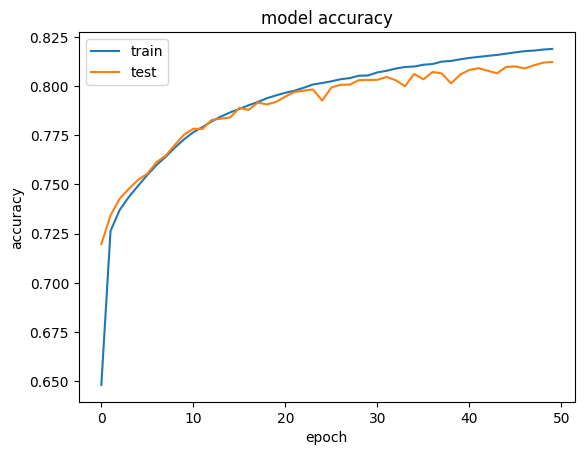

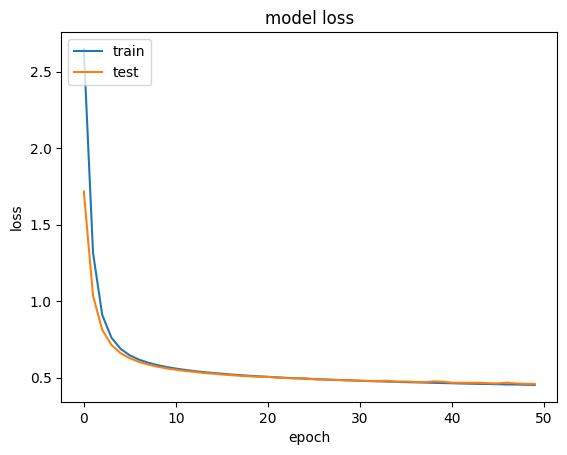

In [94]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dropout, Embedding, Flatten
from keras import regularizers
from keras.optimizers import Adam


vocab_size = len(tokenizer.word_index) + 1

model = Sequential()
embedding_layer = Embedding(vocab_size, 50, weights=[embedding_matrix_vocab], input_length=maxlen , trainable=False)
model.add(embedding_layer)

# Add more convolutional layers with different filter sizes
model.add(Conv1D(128, 3, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(MaxPooling1D(3))
model.add(Conv1D(128, 4, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(MaxPooling1D(4))
model.add(Conv1D(128, 5, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(GlobalMaxPooling1D())

# Add a Dense layer before the output layer
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3)
custome_optimizer = Adam(learning_rate=1.0e-5)
model.compile(optimizer=custome_optimizer, loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, batch_size=128, epochs=50, verbose=1, validation_split=0.2, callbacks=[early_stopping])

scores.update({'more_cnnlayers_train': model.evaluate(X_train, y_train, verbose=1),
              'more_cnnlayers_test': model.evaluate(X_train, y_train, verbose=1)})

import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()